This is drawn almost exactly from https://mochajl.readthedocs.io/en/latest/tutorial/mnist.html with the exception
of the plots at the end

In [1]:
using Mocha

Configuring Mocha...
 * CUDA       disabled by default
 * Native Ext disabled by default
Mocha configured, continue loading module...
DefaultBackend = Mocha.CPUBackend


In [53]:
using Images

In [2]:
data_layer  = HDF5DataLayer(name="train-data", source="data/train.txt",
    batch_size=64, shuffle=true)

Mocha.HDF5DataLayer(train-data)

In [3]:
conv_layer = ConvolutionLayer(name="conv1", n_filter=20, kernel=(5,5),
    bottoms=[:data], tops=[:conv1])

Mocha.ConvolutionLayer(conv1)

In [4]:
pool_layer = PoolingLayer(name="pool1", kernel=(2,2), stride=(2,2),
    bottoms=[:conv1], tops=[:pool1])
conv2_layer = ConvolutionLayer(name="conv2", n_filter=50, kernel=(5,5),
    bottoms=[:pool1], tops=[:conv2])
pool2_layer = PoolingLayer(name="pool2", kernel=(2,2), stride=(2,2),
    bottoms=[:conv2], tops=[:pool2])


Mocha.PoolingLayer(pool2)

In [5]:
fc1_layer  = InnerProductLayer(name="ip1", output_dim=500,
    neuron=Neurons.ReLU(), bottoms=[:pool2], tops=[:ip1])
fc2_layer  = InnerProductLayer(name="ip2", output_dim=10,
    bottoms=[:ip1], tops=[:ip2])

Mocha.InnerProductLayer(ip2)

In [6]:
loss_layer = SoftmaxLossLayer(name="loss", bottoms=[:ip2,:label])

Mocha.SoftmaxLossLayer(loss)

In [7]:
backend = CPUBackend()
init(backend)

In [57]:
common_layers = [conv_layer, pool_layer, conv2_layer, pool2_layer,
    fc1_layer, fc2_layer]
net = Net("MNIST-train", backend, [data_layer, common_layers..., loss_layer])

[2018-10-15 11:47:47 | info | Mocha]: Constructing net MNIST-train on Mocha.CPUBackend...
[2018-10-15 11:47:47 | info | Mocha]: Topological sorting 8 layers...
[2018-10-15 11:47:47 | info | Mocha]: Setup layers...
[2018-10-15 11:47:48 | info | Mocha]: Network constructed!


************************************************************
          NAME: MNIST-train
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.HDF5DataLayer(train-data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 64)
         label: Blob(1 x 64)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 64)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 64)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 64)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 64)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------
    

In [9]:
exp_dir = "snapshots"
method = SGD()
params = make_solver_parameters(method, max_iter=10000, regu_coef=0.0005,
    mom_policy=MomPolicy.Fixed(0.9),
    lr_policy=LRPolicy.Inv(0.01, 0.0001, 0.75),
    load_from=exp_dir)
solver = Solver(method, params)

Mocha.Solver{Mocha.SGD}(Mocha.SGD(), Dict{Symbol,Any}(Pair{Symbol,Any}(:lr_policy, Mocha.LRPolicy.Inv(0.01, 0.0001, 0.75)),Pair{Symbol,Any}(:max_iter, 10000),Pair{Symbol,Any}(:load_from, "snapshots"),Pair{Symbol,Any}(:regu_coef, 0.0005),Pair{Symbol,Any}(:mom_policy, Mocha.MomPolicy.Fixed(0.9))), Mocha.CoffeeLounge("", 1, :merge, Dict{AbstractString,Dict{Int64,AbstractFloat}}(), Mocha.CoffeeBreak[], false, 0, 0))

In [10]:
setup_coffee_lounge(solver, save_into="$exp_dir/statistics.jld", every_n_iter=1000)


:merge

In [11]:
add_coffee_break(solver, TrainingSummary(), every_n_iter=100)

1-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)

In [12]:
add_coffee_break(solver, Snapshot(exp_dir), every_n_iter=5000)


2-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)
 Mocha.CoffeeBreak(Mocha.Snapshot("snapshots"), 5000, 0)               

In [13]:
data_layer_test = HDF5DataLayer(name="test-data", source="data/test.txt", batch_size=100)
acc_layer = AccuracyLayer(name="test-accuracy", bottoms=[:ip2, :label])
test_net = Net("MNIST-test", backend, [data_layer_test, common_layers..., acc_layer])

[2018-10-15 10:05:16 | info | Mocha]: Constructing net MNIST-test on Mocha.CPUBackend...
[2018-10-15 10:05:16 | info | Mocha]: Topological sorting 8 layers...
[2018-10-15 10:05:16 | info | Mocha]: Setup layers...
[2018-10-15 10:05:17 | info | Mocha]: Network constructed!


************************************************************
          NAME: MNIST-test
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.HDF5DataLayer(test-data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 100)
         label: Blob(1 x 100)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 100)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 100)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 100)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 100)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------


In [14]:
add_coffee_break(solver, ValidationPerformance(test_net), every_n_iter=1000);

In [15]:
solve(solver, net)

destroy(net)
destroy(test_net)
shutdown(backend)

[2018-10-15 10:05:24 | info | Mocha]: Snapshot directory snapshots already exists
[2018-10-15 10:05:24 | info | Mocha]:  TRAIN iter=000000 obj_val=2.35863352
[2018-10-15 10:05:24 | info | Mocha]: Saving snapshot to snapshot-000000.jld...
[2018-10-15 10:05:51 | info | Mocha]: 
[2018-10-15 10:05:51 | info | Mocha]: ## Performance on Validation Set after 0 iterations
[2018-10-15 10:05:51 | info | Mocha]: ---------------------------------------------------------
[2018-10-15 10:05:51 | info | Mocha]:   Accuracy (avg over 10000) = 11.9400%
[2018-10-15 10:05:51 | info | Mocha]: ---------------------------------------------------------
[2018-10-15 10:05:51 | info | Mocha]: 
[2018-10-15 10:06:11 | info | Mocha]:  TRAIN iter=000100 obj_val=0.31432045
[2018-10-15 10:06:29 | info | Mocha]:  TRAIN iter=000200 obj_val=0.40184593
[2018-10-15 10:06:47 | info | Mocha]:  TRAIN iter=000300 obj_val=0.05584858
[2018-10-15 10:07:06 | info | Mocha]:  TRAIN iter=000400 obj_val=0.11465108
[2018-10-15 10:07:24 

[2018-10-15 10:27:59 | info | Mocha]:  TRAIN iter=006500 obj_val=0.01050950
[2018-10-15 10:28:17 | info | Mocha]:  TRAIN iter=006600 obj_val=0.01444964
[2018-10-15 10:28:35 | info | Mocha]:  TRAIN iter=006700 obj_val=0.00743677
[2018-10-15 10:28:54 | info | Mocha]:  TRAIN iter=006800 obj_val=0.03480780
[2018-10-15 10:29:12 | info | Mocha]:  TRAIN iter=006900 obj_val=0.01133169
[2018-10-15 10:29:30 | info | Mocha]:  TRAIN iter=007000 obj_val=0.01745046
[2018-10-15 10:29:55 | info | Mocha]: 
[2018-10-15 10:29:55 | info | Mocha]: ## Performance on Validation Set after 7000 iterations
[2018-10-15 10:29:55 | info | Mocha]: ---------------------------------------------------------
[2018-10-15 10:29:55 | info | Mocha]:   Accuracy (avg over 10000) = 99.1200%
[2018-10-15 10:29:55 | info | Mocha]: ---------------------------------------------------------
[2018-10-15 10:29:55 | info | Mocha]: 
[2018-10-15 10:30:13 | info | Mocha]:  TRAIN iter=007100 obj_val=0.00885139
[2018-10-15 10:30:32 | info 

Dict{AbstractString,Array{Mocha.AbstractParameter,1}} with 0 entries

In [59]:
open("net.dot", "w") do out net2dot(out, net) end
# in shell run " dot -Tpng net.dot |> "net.png" " to generate png. this can also be doing using `run` in julia, 
#  but `run` doesn't behave as well in jupyter notebook

In [16]:
backend = CPUBackend()
init(backend)

mem_data = MemoryDataLayer(name="data", tops=[:data], batch_size=1,
    data=Array[zeros(Float32, 28, 28, 1, 1)])
softmax_layer = SoftmaxLayer(name="prob", tops=[:prob], bottoms=[:ip2])

# define common_layers as earlier

run_net = Net("imagenet", backend, [mem_data, common_layers..., softmax_layer])

[2018-10-15 10:41:53 | info | Mocha]: Constructing net imagenet on Mocha.CPUBackend...
[2018-10-15 10:41:53 | info | Mocha]: Topological sorting 8 layers...
[2018-10-15 10:41:53 | info | Mocha]: Setup layers...
[2018-10-15 10:41:53 | info | Mocha]: Network constructed!


************************************************************
          NAME: imagenet
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.MemoryDataLayer(data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 1)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 1)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 1)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------
         pool1: Blob(12 x 12 x 20 x 1)
    Ou

In [18]:
load_snapshot(run_net, "snapshots/snapshot-010000.jld")

[2018-10-15T00:21:01 | info | Mocha]: Loading existing model from snapshots/snapshot-010000.jld


Mocha.SolverState{Mocha.SGDSolverState}(10000, 0.023743240162730217, Dict{Any,Any}(), Mocha.SGDSolverState(0.005946035575013605, 0.9, Mocha.LayerState[Mocha.ConvolutionLayerState(Mocha.ConvolutionLayer(conv1), Mocha.Blob[Blob(24 x 24 x 20 x 1)], Mocha.Blob[Blob(24 x 24 x 20 x 1)], Mocha.Parameter[Mocha.Parameter("filter", Blob(5 x 5 x 1 x 20), Blob(5 x 5 x 1 x 20), Mocha.NullInitializer(), Mocha.L2Regu(1.0), Mocha.NoCons(0.0, 0), 1.0, Mocha.RefCounter(2)), Mocha.Parameter("bias", Blob(20), Blob(20), Mocha.NullInitializer(), Mocha.NoRegu(0.0), Mocha.NoCons(0.0, 0), 2.0, Mocha.RefCounter(2))], Blob(5 x 5 x 1 x 20), Blob(5 x 5 x 1 x 20), Blob(20), Blob(20), 24, 24, Mocha.CPUConvState(Blob(24 x 24 x 25 x 1), 576, 20, 25, Blob(576 x 1 x 1 x 1), Float32[0.0 0.00615451 … 0.0 NaN32; 0.0 4.58155f-41 … 0.0 NaN32; … ; 0.00615356 0.00615487 … 0.0 1.4013f-45; 4.58155f-41 4.58155f-41 … 0.0 0.0]), false), Mocha.ConvolutionLayerState(Mocha.ConvolutionLayer(conv2), Mocha.Blob[Blob(8 x 8 x 50 x 1)], Moc

In [17]:
using HDF5
h5open("data/test.hdf5") do f
    get_layer(run_net, "data").data[1][:,:,1,1] = f["data"][:,:,1,1]
    println("Correct label index: ", Int64(f["label"][:,1][1]+1))
end

forward(run_net)
println()
println("Label probability vector:")
println(run_net.output_blobs[:prob].data)

Correct label index: 9


LoadError: [91mInexactError()[39m

In [19]:
using PyPlot, JLD

INFO: Precompiling module PyPlot.
Info: Installing matplotlib via the Conda matplotlib package...
Info: Running `conda install -y matplotlib` in root environment


Solving environment: ...working... done


matplotlib-3.0.0     | 6.8 MB    | ########## | 100% 
pytz-2018.5          | 231 KB    | ########## | 100% 
freetype-2.9.1       | 864 KB    | ########## | 100% 
pyparsing-2.2.2      | 97 KB     | ########## | 100% 
kiwisolver-1.0.1     | 56 KB     | ########## | 100% 
cycler-0.10.0        | 13 KB     |            |   0% 


## Package Plan ##

  environment location: /Users/max/.julia/v0.6/Conda/deps/usr

  added / updated specs: 
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.0.0           |   py36h54f8f79_0         6.8 MB
    pytz-2018.5                |           py36_0         231 KB
    freetype-2.9.1             |       hb4e5f40_0         864 KB
    pyparsing-2.2.2            |           py36_0          97 KB
    kiwisolver-1.0.1           |   py36h0a44026_0          56 KB
    cycler-0.10.0              |   py36hfc81398_0          13 KB
    ------------------------------------------------------------
                                           Total:         8.1 MB

The following NEW packages will be INSTALLED:

    cycler:     0.10.0-py36hfc81398_0
    freetype:   2.9.1-hb4e5f40_0     
    kiwisolver: 1.0.1-py36h0a44026_0 
    matplotlib: 3.0.0-py36h54f8f79_0 
    pyp

cycler-0.10.0        | 13 KB     | ########## | 100% 

done
Executing transaction: ...working... done



Unable to revert mtime: /Library/Fonts


In [20]:
stats = load("snapshots/statistics.jld")
# println(typeof(stats))

tables = stats["statistics"]
ov = tables["obj_val"]
xy = sort(collect(ov))
x = [i for (i,j) in xy]
y = [j for (i,j) in xy]
x = convert(Array{Int64}, x)
y = convert(Array{Float64}, y)

101-element Array{Float64,1}:
 2.35863   
 0.31432   
 0.401846  
 0.0558486 
 0.114651  
 0.0933054 
 0.0646854 
 0.100322  
 0.0912237 
 0.0392795 
 0.0950138 
 0.0677079 
 0.0164671 
 ⋮         
 0.0848198 
 0.00719142
 0.0100522 
 0.0185576 
 0.00218554
 0.0184697 
 0.00609653
 0.0124449 
 0.00435782
 0.0129605 
 0.0471828 
 0.00374144

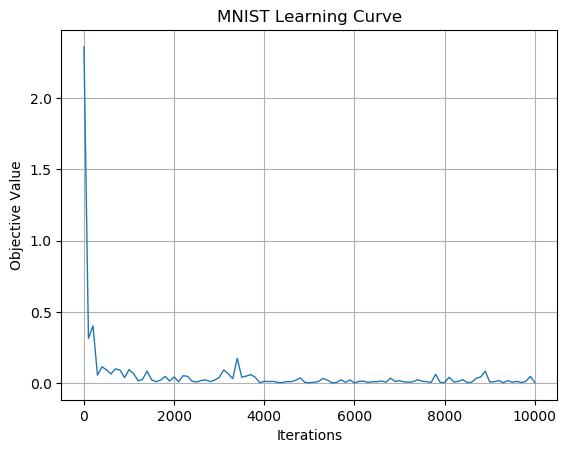

In [21]:
raw = plot(x, y, linewidth=1, label="Raw")
xlabel("Iterations")
ylabel("Objective Value")
title("MNIST Learning Curve")
grid("on")

In [23]:
model_params = load("snapshots/snapshot-010000.jld")

Dict{String,Any} with 2 entries:
  "solver_state" => Mocha.SGDSolverSnapshot(10000, 0.00374144, 0.00594604, 0.9)
  "params_all"   => Dict{AbstractString,Array{Array,1}}(Pair{AbstractString,Arr…

In [25]:
model_params["params_all"]

Dict{AbstractString,Array{Array,1}} with 4 entries:
  "ip2"   => Array[Float32[-0.0715912 -0.0125504 … -0.104517 -0.0293323; 0.0072…
  "conv1" => Array[Float32[-0.171826 0.0634308 … 0.0607307 -0.176374; -0.017870…
  "ip1"   => Array[Float32[0.00907153 0.0125436 … -0.0148428 0.0175151; 0.00276…
  "conv2" => Array[Float32[0.0534353 0.01805 … -0.020137 -0.00508149; 0.0362335…

In [33]:
model_params["params_all"]["conv1"]

2-element Array{Array,1}:
 Float32[-0.171826 0.0634308 … 0.0607307 -0.176374; -0.0178705 0.192093 … 0.0887122 -0.220021; … ; 0.0324766 0.260353 … -0.287754 0.0459051; 0.198959 0.0594657 … -0.202151 -0.0524436]

Float32[-0.224579 -0.0578851 … 0.255156 0.136309; 0.029705 -0.290497 … -0.00408163 0.190921; … ; 0.00867588 -0.278292 … 0.1715 -0.0887297; -0.177925 -0.242972 … 0.109208 0.120995]

Float32[-0.134894 -0.251856 … -0.202346 -0.0626241; -0.225242 -0.0181353 … 0.12393 0.085449; … ; -0.00758352 -0.0673803 … 0.134056 -0.0729489; 0.122044 0.158463 … 0.297107 0.265298]

...

Float32[0.0730137 -0.10888 … -0.181912 0.239938; -0.0656181 -0.155031 … -0.131014 0.165729; … ; -0.0980529 -0.282158 … 0.242684 0.41583; 0.0288336 -0.395337 … 0.296603 0.305097]

Float32[-0.183128 0.011241 … -0.114522 0.203891; -0.0829642 -0.158475 … -0.0669122 0.261412; … ; -0.247596 -0.17917 … 0.43524 0.228052; 0.0484358 0.113559 … 0.117319 0.0476397]

Float32[0.334834 0.129301 … -0.0811692 -0.116564; 0.400003 -0.0

In [40]:
model_params["params_all"]["conv1"][1]

5×5×1×20 Array{Float32,4}:
[:, :, 1, 1] =
 -0.171826   0.0634308   0.0627395   0.0607307  -0.176374 
 -0.0178705  0.192093   -0.069016    0.0887122  -0.220021 
  0.11218    0.30785    -0.0535392  -0.104049   -0.29606  
  0.0324766  0.260353   -0.096002   -0.287754    0.0459051
  0.198959   0.0594657   0.0230666  -0.202151   -0.0524436

[:, :, 1, 2] =
 -0.224579    -0.0578851  -0.00107737   0.255156     0.136309 
  0.029705    -0.290497    0.0965477   -0.00408163   0.190921 
 -0.176325    -0.215178   -0.0562089    0.22316     -0.0882827
  0.00867588  -0.278292   -0.111666     0.1715      -0.0887297
 -0.177925    -0.242972    0.0632314    0.109208     0.120995 

[:, :, 1, 3] =
 -0.134894    -0.251856   -0.140275   -0.202346  -0.0626241
 -0.225242    -0.0181353  -0.162968    0.12393    0.085449 
 -0.0941872   -0.0343186   0.0670251  -0.116209  -0.10128  
 -0.00758352  -0.0673803   0.0377105   0.134056  -0.0729489
  0.122044     0.158463    0.22973     0.297107   0.265298 

...

[:, :, 1, 

In [37]:
filter_img = model_params["params_all"]["conv1"][1][:,:,1,1]

5×5 Array{Float32,2}:
 -0.171826   0.0634308   0.0627395   0.0607307  -0.176374 
 -0.0178705  0.192093   -0.069016    0.0887122  -0.220021 
  0.11218    0.30785    -0.0535392  -0.104049   -0.29606  
  0.0324766  0.260353   -0.096002   -0.287754    0.0459051
  0.198959   0.0594657   0.0230666  -0.202151   -0.0524436

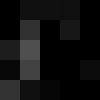

In [39]:
filter_img = Gray.(filter_img)

In [41]:
filters=[]

0-element Array{Any,1}

In [44]:
for i = 1:20
    push!(filters, Gray.(model_params["params_all"]["conv1"][1][:,:,1,i]))
end

In [45]:
filters

20-element Array{Any,1}:
 ColorTypes.Gray{Float32}[Gray{Float32}(-0.171826) Gray{Float32}(0.0634308) … Gray{Float32}(0.0607307) Gray{Float32}(-0.176374); Gray{Float32}(-0.0178705) Gray{Float32}(0.192093) … Gray{Float32}(0.0887122) Gray{Float32}(-0.220021); … ; Gray{Float32}(0.0324766) Gray{Float32}(0.260353) … Gray{Float32}(-0.287754) Gray{Float32}(0.0459051); Gray{Float32}(0.198959) Gray{Float32}(0.0594657) … Gray{Float32}(-0.202151) Gray{Float32}(-0.0524436)]  
 ColorTypes.Gray{Float32}[Gray{Float32}(-0.224579) Gray{Float32}(-0.0578851) … Gray{Float32}(0.255156) Gray{Float32}(0.136309); Gray{Float32}(0.029705) Gray{Float32}(-0.290497) … Gray{Float32}(-0.00408163) Gray{Float32}(0.190921); … ; Gray{Float32}(0.00867588) Gray{Float32}(-0.278292) … Gray{Float32}(0.1715) Gray{Float32}(-0.0887297); Gray{Float32}(-0.177925) Gray{Float32}(-0.242972) … Gray{Float32}(0.109208) Gray{Float32}(0.120995)]     
 ColorTypes.Gray{Float32}[Gray{Float32}(-0.134894) Gray{Float32}(-0.251856) … Gray{Float3

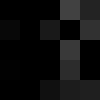

In [46]:
filters[2]

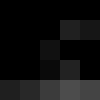

In [47]:
filters[3]

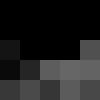

In [48]:
filters[4]

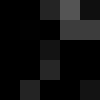

In [49]:
filters[5]

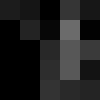

In [50]:
filters[6]

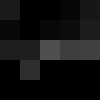

In [51]:
filters[7]

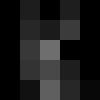

In [54]:
filters[8]

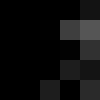

In [55]:
filters[9]

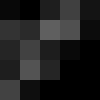

In [56]:
filters[10]